# Importing the dataset

In [1]:
import pandas as pd

# df = pd.read_csv("DelayedFlights.csv")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting the display options
pd.set_option("display.float_format", "{:,.2f}".format)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

In [5]:
# Define optimized data types
dtype_map = {
    "id": "int64",
    "Year": "int16", "Month": "int8", "DayofMonth": "int8", "DayOfWeek": "int8",
    "DepTime": "float32", "CRSDepTime": "float32",
    "ArrTime": "float32", "CRSArrTime": "float32",
    "UniqueCarrier": "string", "FlightNum": "string", "TailNum": "string",
    "ActualElapsedTime": "float32", "CRSElapsedTime": "float32", "AirTime": "float32",
    "ArrDelay": "float32", "DepDelay": "float32",
    "Origin": "string", "Dest": "string", "Distance": "int32",
    "TaxiIn": "float32", "TaxiOut": "float32",
    "Cancelled": "int8", "CancellationCode": "string", "Diverted": "int8",
    "CarrierDelay": "float32", "WeatherDelay": "float32",
    "NASDelay": "float32", "SecurityDelay": "float32", "LateAircraftDelay": "float32",
}
df = pd.read_csv("DelayedFlights.csv", dtype=dtype_map)
print(f"Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

Data loaded: 1,936,758 rows, 30 columns


## EDA and Data Integrity check

In [7]:
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,"2,003.00","1,955.00","2,211.00","2,225.00",WN,335,N712SW,128.00,150.00,116.00,-14.00,8.00,IAD,TPA,810,4.00,8.00,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.00,735.00,"1,002.00","1,000.00",WN,3231,N772SW,128.00,145.00,113.00,2.00,19.00,IAD,TPA,810,5.00,10.00,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.00,620.00,804.00,750.00,WN,448,N428WN,96.00,90.00,76.00,14.00,8.00,IND,BWI,515,3.00,17.00,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,"1,829.00","1,755.00","1,959.00","1,925.00",WN,3920,N464WN,90.00,90.00,77.00,34.00,34.00,IND,BWI,515,3.00,10.00,0,N,0,2.00,0.00,0.00,0.00,32.00
4,5,2008,1,3,4,"1,940.00","1,915.00","2,121.00","2,110.00",WN,378,N726SW,101.00,115.00,87.00,11.00,25.00,IND,JAX,688,4.00,10.00,0,N,0,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df.rename(columns={'Unnamed: 0': 'id'})

In [9]:
print("data overview")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\ndatatypes")
print(df.dtypes.value_counts())

print("\nmissing")
missing_data = df.isna().sum()
missing_pct = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_info.head(15))

print("\nduplicate")
print(f"Duplicate IDs: {df.duplicated(subset=['id']).sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

print("\nbasic stats")
print(df.describe())

data overview
Shape: (1936758, 30)
Memory usage: 730.64 MB

datatypes
float32           16
string[python]     6
int8               5
int64              1
int16              1
int32              1
Name: count, dtype: int64

missing
                   Missing Count  Missing %
NASDelay                  689270      35.59
CarrierDelay              689270      35.59
LateAircraftDelay         689270      35.59
SecurityDelay             689270      35.59
WeatherDelay              689270      35.59
ActualElapsedTime           8387       0.43
AirTime                     8387       0.43
ArrDelay                    8387       0.43
TaxiIn                      7110       0.37
ArrTime                     7110       0.37
TaxiOut                      455       0.02
CRSElapsedTime               198       0.01
TailNum                        5       0.00
id                             0       0.00
FlightNum                      0       0.00

duplicate
Duplicate IDs: 0
Duplicate rows: 0

basic stats
      

## Building flight date

In [10]:
df["FlightDate"] = pd.to_datetime(
    dict(year=df["Year"], month=df["Month"], day=df["DayofMonth"]), 
    errors="coerce"
)

# Checking for invalid dates
invalid_dates = df["FlightDate"].isna().sum()
print(f"Invalid dates: {invalid_dates} ({invalid_dates/len(df)*100:.4f}%)")

# Removeing invalid
if invalid_dates > 0:
    df = df[df["FlightDate"].notna()]
    print(f"Removed {invalid_dates} rows with invalid dates")

Invalid dates: 0 (0.0000%)


## Parse hhmm Times to Time/DateTime with Overnight Adjustment

In [11]:
def hhmm_to_hm(series):
    """Convert hhmm format to separate hour and minute components"""
    # Convert to nullable integer
    s = pd.Series(series, dtype="float32").astype("Int64")
    # Zero-pad to 4 characters
    z = s.astype("string").str.zfill(4)
    # Extract hours and minutes
    h = z.str[:2].astype("Int64")
    m = z.str[2:].astype("Int64")
    return h, m
    
time_columns = ["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime"]

for col in time_columns:
    print(f"Processing {col}...")
    h, m = hhmm_to_hm(df[col])
    df[f"{col}_Hour"] = h
    df[f"{col}_Min"] = m

def build_dt(date_col, hour_col, min_col):
    return pd.to_datetime(
        df[date_col].astype("string") + " " +
        df[hour_col].astype("string").str.zfill(2) + ":" +
        df[min_col].astype("string").str.zfill(2),
        errors="coerce"
    )

print("Creating datetime columns...")
df["DepDateTime"] = build_dt("FlightDate", "DepTime_Hour", "DepTime_Min")
df["CRSDepDateTime"] = build_dt("FlightDate", "CRSDepTime_Hour", "CRSDepTime_Min")
df["ArrDateTime_raw"] = build_dt("FlightDate", "ArrTime_Hour", "ArrTime_Min")
df["CRSArrDateTime_raw"] = build_dt("FlightDate", "CRSArrTime_Hour", "CRSArrTime_Min")

# Identify overnight flights (arrival time earlier than departure time)
overnight_mask = (
    (df["ArrTime_Hour"].notna() & df["DepTime_Hour"].notna()) & 
    (
        (df["ArrTime_Hour"] < df["DepTime_Hour"]) |
        ((df["ArrTime_Hour"] == df["DepTime_Hour"]) & (df["ArrTime_Min"] < df["DepTime_Min"]))
    )
)

print(f"Overnight flights detected: {overnight_mask.sum():,}")

# Apply overnight adjustment
df["ArrDateTime"] = df["ArrDateTime_raw"].where(
    ~overnight_mask, 
    df["ArrDateTime_raw"] + pd.Timedelta(days=1)
)
df["CRSArrDateTime"] = df["CRSArrDateTime_raw"].where(
    ~overnight_mask, 
    df["CRSArrDateTime_raw"] + pd.Timedelta(days=1)
)

Processing DepTime...
Processing CRSDepTime...
Processing ArrTime...
Processing CRSArrTime...
Creating datetime columns...
Overnight flights detected: 111,575


##  Handle Cancellations and Diversions

Cancelled flights: 633 (0.03%)
Diverted flights: 7,754 (0.40%)


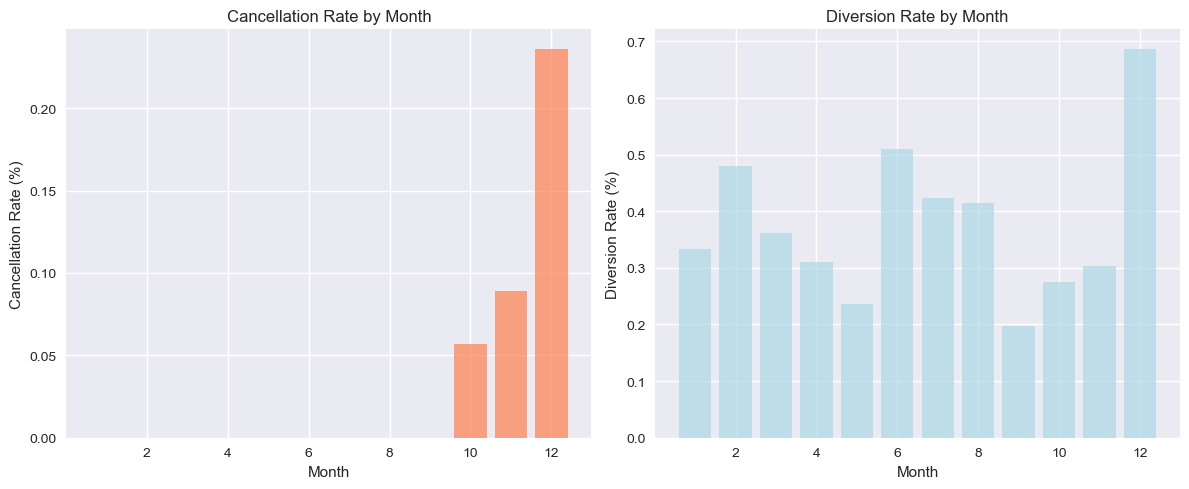

In [12]:
df["Cancelled"] = df["Cancelled"].astype(bool)
df["Diverted"] = df["Diverted"].astype(bool)

print(f"Cancelled flights: {df['Cancelled'].sum():,} ({df['Cancelled'].mean()*100:.2f}%)")
print(f"Diverted flights: {df['Diverted'].sum():,} ({df['Diverted'].mean()*100:.2f}%)")

# Visualization: Cancellation and Diversion Rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Cancellation rate by month
cancelled_by_month = df.groupby('Month')['Cancelled'].mean()
ax1.bar(cancelled_by_month.index, cancelled_by_month.values * 100, color='coral', alpha=0.7)
ax1.set_title('Cancellation Rate by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Cancellation Rate (%)')

# Diversion rate by month
diverted_by_month = df.groupby('Month')['Diverted'].mean()
ax2.bar(diverted_by_month.index, diverted_by_month.values * 100, color='lightblue', alpha=0.7)
ax2.set_title('Diversion Rate by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Diversion Rate (%)')

plt.tight_layout()
plt.show()

## Normalize Delay Cause Fields

In [14]:
cause_cols = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]

print("Normalizing delay cause fields...")
mask_completed = (~df["Cancelled"]) & (~df["Diverted"])
print(f"Completed flights: {mask_completed.sum():,}")

# Fill NaN with 0 for completed flights, keep as NaN for cancelled/diverted
df.loc[mask_completed, cause_cols] = df.loc[mask_completed, cause_cols].fillna(0)

print("Delay cause summary (completed flights only):")
completed_flights = df[mask_completed]
for col in cause_cols:
    non_zero = (completed_flights[col] > 0).sum()
    print(f"{col}: {non_zero:,} flights affected ({non_zero/len(completed_flights)*100:.1f}%)")

Normalizing delay cause fields...
Completed flights: 1,928,371
Delay cause summary (completed flights only):
CarrierDelay: 656,439 flights affected (34.0%)
WeatherDelay: 98,918 flights affected (5.1%)
NASDelay: 658,493 flights affected (34.1%)
SecurityDelay: 6,005 flights affected (0.3%)
LateAircraftDelay: 691,582 flights affected (35.9%)


## Duplicate Handling

In [15]:
print("Handling duplicates...")
initial_count = len(df)

# Drop perfect duplicates
df = df.drop_duplicates()
after_perfect_dedup = len(df)
print(f"Rows after perfect duplicate removal: {after_perfect_dedup:,}")

# Handling duplicate id
dupe_ids = df.duplicated(subset=["id"], keep=False)
print(f"Duplicate IDs found: {dupe_ids.sum()}")

if dupe_ids.sum() > 0:
    print("Sample of duplicate IDs:")
    print(df[dupe_ids].sort_values("id").head(10))
    
    # Keep first occurrence for each ID
    df = df.drop_duplicates(subset=["id"], keep="first")
    print(f"Rows after ID deduplication: {len(df):,}")

final_count = len(df)
print(f"Total rows removed: {initial_count - final_count:,}")

Handling duplicates...
Rows after perfect duplicate removal: 1,936,758
Duplicate IDs found: 0
Total rows removed: 0


## Enhance feature eng for KPI

In [16]:
# Delay flags (keep negative delays as-is)
df["ArrDel15"] = (df["ArrDelay"] >= 15).astype("Int8")
df["DepDel15"] = (df["DepDelay"] >= 15).astype("Int8")

def delay_bucket(x):
    """Categorize delay into buckets"""
    if pd.isna(x): 
        return pd.NA
    if x < 0: 
        return "Early"
    if x < 15:
        return "On-Time (<15)"
    if x <= 45:
        return "Delay 15-45"
    return "Delay >45"

df["DelayCategory"] = df["ArrDelay"].apply(delay_bucket)

# Time-based features
df["HourOfDay"] = df["DepTime_Hour"].astype("float").astype("Int64")
df["DayName"] = df["FlightDate"].dt.day_name()
df["MonthName"] = df["FlightDate"].dt.month_name()
df["Route"] = df["Origin"].astype("string") + " → " + df["Dest"].astype("string")

# Total delay minutes by cause for completed flights
df["TotalDelayMinutes"] = df[cause_cols].sum(axis=1, skipna=True)
df.loc[~mask_completed, "TotalDelayMinutes"] = pd.NA

print("Feature engineering completed!")
print(f"Arrival delay >15 min: {df['ArrDel15'].mean()*100:.2f}% of flights")

Feature engineering completed!
Arrival delay >15 min: 64.41% of flights


##  Enhanced Sanity and Consistency Checks

Mismatch rate (ArrDelay>0 but TotalDelayMinutes=0): 24.68%

Delay statistics (completed flights only):
          ArrDelay     DepDelay  TotalDelayMinutes
count 1,928,371.00 1,928,371.00       1,928,371.00
mean         42.20        43.09              40.94
std          56.75        53.25              57.38
min        -109.00         6.00               0.00
25%           9.00        12.00               0.00
50%          24.00        24.00              24.00
75%          56.00        53.00              56.00
max       2,461.00     2,467.00           2,461.00


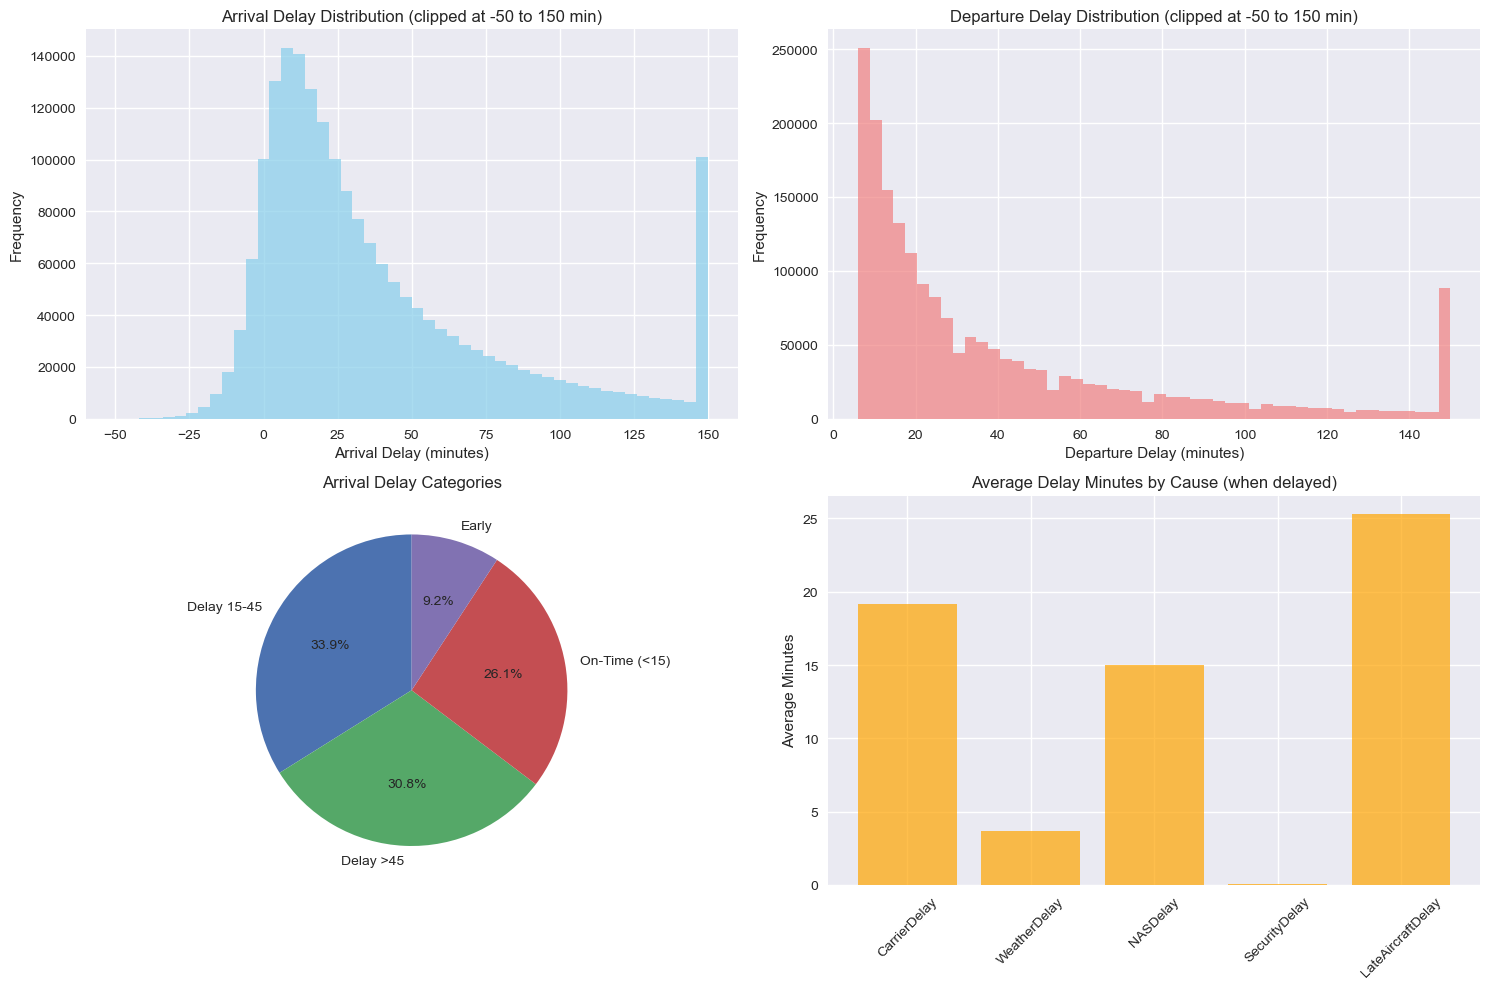

In [17]:
# Compare ArrDelay vs sum of delay causes
comp = df[mask_completed]
mismatch = (comp["ArrDelay"] > 0) & (comp["TotalDelayMinutes"] == 0)
mismatch_rate = mismatch.mean()
print(f"Mismatch rate (ArrDelay>0 but TotalDelayMinutes=0): {mismatch_rate*100:.2f}%")
# Check delay distributions
print("\nDelay statistics (completed flights only):")
delay_stats = comp[["ArrDelay", "DepDelay", "TotalDelayMinutes"]].describe()
print(delay_stats)
# Visualization: Delay Distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Arrival Delay distribution (zoomed in)
axes[0,0].hist(comp["ArrDelay"].clip(-50, 150), bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Arrival Delay Distribution (clipped at -50 to 150 min)')
axes[0,0].set_xlabel('Arrival Delay (minutes)')
axes[0,0].set_ylabel('Frequency')
# Departure Delay distribution (zoomed in)
axes[0,1].hist(comp["DepDelay"].clip(-50, 150), bins=50, alpha=0.7, color='lightcoral')
axes[0,1].set_title('Departure Delay Distribution (clipped at -50 to 150 min)')
axes[0,1].set_xlabel('Departure Delay (minutes)')
axes[0,1].set_ylabel('Frequency')
# Delay categories
delay_cats = comp['DelayCategory'].value_counts()
axes[1,0].pie(delay_cats.values, labels=delay_cats.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Arrival Delay Categories')
# Delay causes (when delay > 0)
delay_causes = comp[comp["TotalDelayMinutes"] > 0][cause_cols].mean()
axes[1,1].bar(delay_causes.index, delay_causes.values, color='orange', alpha=0.7)
axes[1,1].set_title('Average Delay Minutes by Cause (when delayed)')
axes[1,1].set_ylabel('Average Minutes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Build Dimension Tables

In [18]:
# Date dimension
date_min, date_max = df["FlightDate"].min(), df["FlightDate"].max()
date_dim = pd.DataFrame({"Date": pd.date_range(date_min, date_max, freq="D")})
date_dim["Year"] = date_dim["Date"].dt.year
date_dim["Quarter"] = "Q" + date_dim["Date"].dt.quarter.astype(str)
date_dim["Month"] = date_dim["Date"].dt.month
date_dim["MonthName"] = date_dim["Date"].dt.month_name()
date_dim["DayOfWeek"] = date_dim["Date"].dt.weekday + 1  # 1=Mon .. 7=Sun
date_dim["DayName"] = date_dim["Date"].dt.day_name()
date_dim["IsWeekend"] = date_dim["DayOfWeek"].isin([6, 7])
print(f"Date dimension: {len(date_dim):,} rows")
# Airlines dimension
airlines_dim = df[["UniqueCarrier"]].dropna().drop_duplicates().rename(columns={"UniqueCarrier":"CarrierCode"})
print(f"Airlines dimension: {len(airlines_dim):,} carriers")
# Airports dimension (union of Origin and Dest)
orig = df[["Origin"]].dropna().rename(columns={"Origin":"AirportCode"})
dest = df[["Dest"]].dropna().rename(columns={"Dest":"AirportCode"})
airports_dim = pd.concat([orig, dest], ignore_index=True).drop_duplicates()
print(f"Airports dimension: {len(airports_dim):,} airports")
# Add some basic stats to dimensions
# For airlines: calculate average delay
airline_stats = df.groupby("UniqueCarrier").agg({
    "ArrDel15": "mean",
    "ArrDelay": "mean",
    "id": "count"
}).round(3)
airlines_dim = airlines_dim.merge(
    airline_stats, 
    left_on="CarrierCode", 
    right_index=True
).rename(columns={"id": "FlightCount", "ArrDel15": "AvgDelayRate", "ArrDelay": "AvgDelayMinutes"})

print("\nTop 10 carriers by delay rate:")
print(airlines_dim.nlargest(10, 'AvgDelayRate')[['CarrierCode', 'AvgDelayRate', 'FlightCount']])

Date dimension: 366 rows
Airlines dimension: 20 carriers
Airports dimension: 305 airports

Top 10 carriers by delay rate:
       CarrierCode  AvgDelayRate  FlightCount
40993           YV          0.76        67063
46897           OH          0.75        52657
30733           XE          0.69       103663
100314          EV          0.69        81877
130295          NW          0.69        79108
168227          B6          0.69        55315
145160          AA          0.69       191865
115815          MQ          0.69       141920
138532          9E          0.69        51885
66587           UA          0.68       141426


## Curate Analytical Fact Table

In [19]:
print("Curating analytical fact table")
fact_cols = [
    "id", "FlightDate", "Year", "Month", "DayofMonth", "DayOfWeek",
    "DepDateTime", "CRSDepDateTime", "ArrDateTime", "CRSArrDateTime",
    "UniqueCarrier", "FlightNum", "TailNum", "Origin", "Dest", "Distance",
    "ActualElapsedTime", "CRSElapsedTime", "AirTime", "TaxiIn", "TaxiOut",
    "ArrDelay", "DepDelay", "ArrDel15", "DepDel15", "DelayCategory",
    "Cancelled", "CancellationCode", "Diverted",
    "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay",
    "TotalDelayMinutes", "HourOfDay", "DayName", "MonthName", "Route"
]

fact = df[fact_cols].copy()
print(f"Fact table curated: {fact.shape[0]:,} rows, {fact.shape[1]} columns")

Curating analytical fact table
Fact table curated: 1,936,758 rows, 39 columns


## Enhanced EDA Visualizations

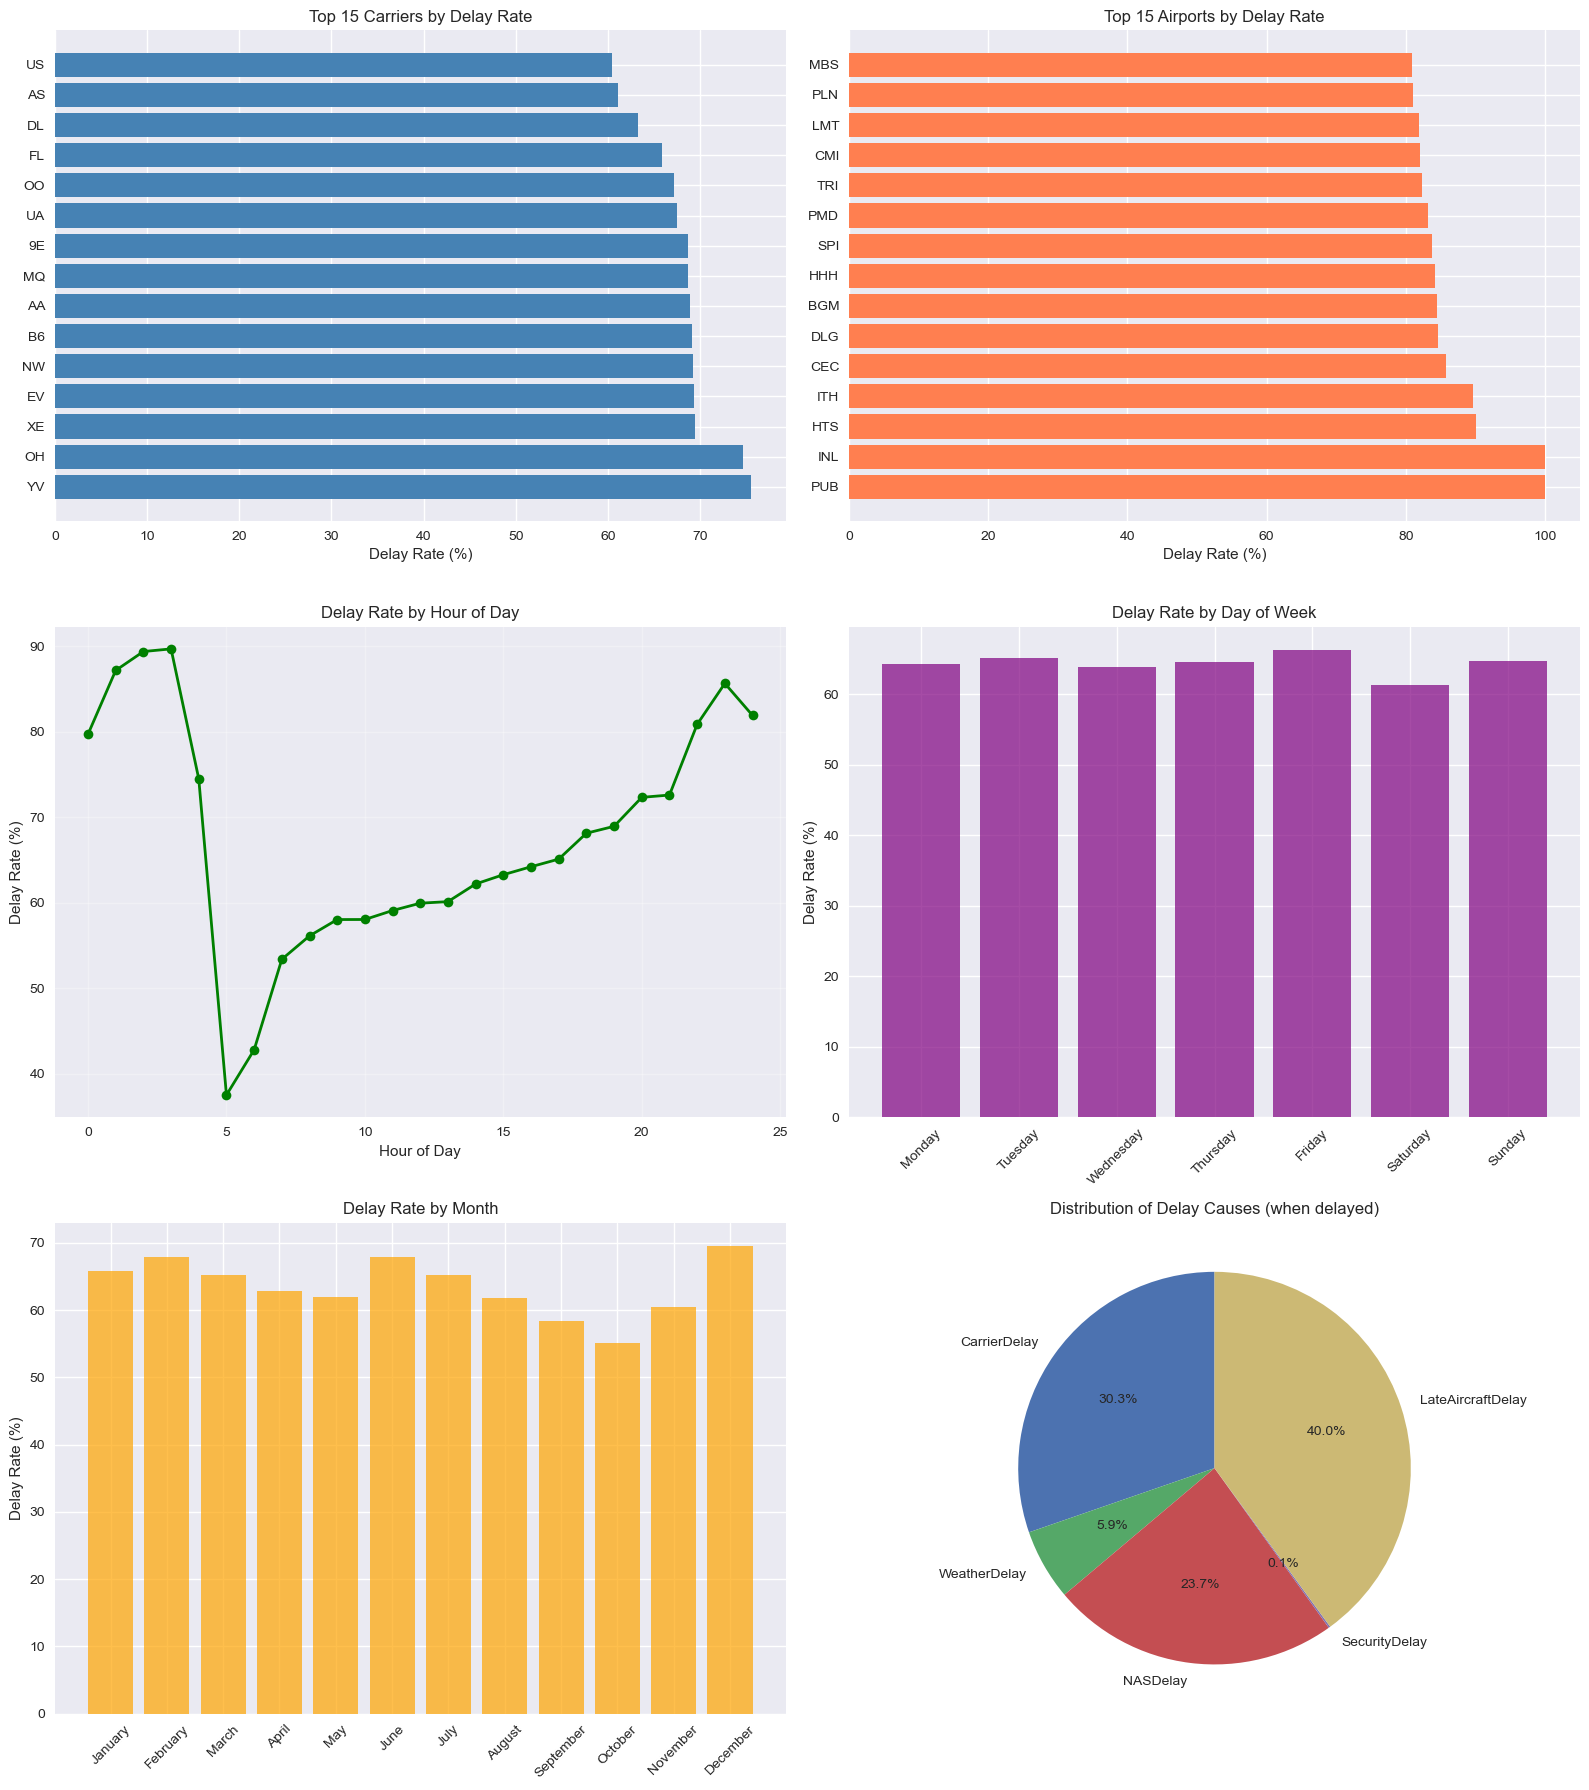


KPI
Total flights: 1,936,758
Completed flights: 1,928,371 (99.6%)
Overall delay rate: 64.41%
Average arrival delay: 42.20 minutes
Average departure delay: 43.19 minutes
Cancellation rate: 0.03%
Diversion rate: 0.40%


In [22]:
# Set up the plotting style
plt.rcParams['figure.figsize'] = (15, 12)

# Create a comprehensive dashboard
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Delay rate by carrier (top 15)
carrier_delays = fact.groupby('UniqueCarrier')['ArrDel15'].mean().sort_values(ascending=False).head(15)
axes[0,0].barh(range(len(carrier_delays)), carrier_delays.values * 100, color='steelblue')
axes[0,0].set_yticks(range(len(carrier_delays)))
axes[0,0].set_yticklabels(carrier_delays.index)
axes[0,0].set_xlabel('Delay Rate (%)')
axes[0,0].set_title('Top 15 Carriers by Delay Rate')

# 2. Delay rate by airport (top 15)
airport_delays = fact.groupby('Origin')['ArrDel15'].mean().sort_values(ascending=False).head(15)
axes[0,1].barh(range(len(airport_delays)), airport_delays.values * 100, color='coral')
axes[0,1].set_yticks(range(len(airport_delays)))
axes[0,1].set_yticklabels(airport_delays.index)
axes[0,1].set_xlabel('Delay Rate (%)')
axes[0,1].set_title('Top 15 Airports by Delay Rate')

# 3. Delay rate by hour of day
hourly_delays = fact.groupby('HourOfDay')['ArrDel15'].mean()
axes[1,0].plot(hourly_delays.index, hourly_delays.values * 100, marker='o', linewidth=2, color='green')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Delay Rate (%)')
axes[1,0].set_title('Delay Rate by Hour of Day')
axes[1,0].grid(True, alpha=0.3)

# 4. Delay rate by day of week
dow_delays = fact.groupby('DayName')['ArrDel15'].mean()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_delays = dow_delays.reindex(dow_order)
axes[1,1].bar(range(len(dow_delays)), dow_delays.values * 100, color='purple', alpha=0.7)
axes[1,1].set_xticks(range(len(dow_delays)))
axes[1,1].set_xticklabels(dow_delays.index, rotation=45)
axes[1,1].set_ylabel('Delay Rate (%)')
axes[1,1].set_title('Delay Rate by Day of Week')

# 5. Delay rate by month
monthly_delays = fact.groupby('MonthName')['ArrDel15'].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_delays = monthly_delays.reindex(month_order)
axes[2,0].bar(range(len(monthly_delays)), monthly_delays.values * 100, color='orange', alpha=0.7)
axes[2,0].set_xticks(range(len(monthly_delays)))
axes[2,0].set_xticklabels(monthly_delays.index, rotation=45)
axes[2,0].set_ylabel('Delay Rate (%)')
axes[2,0].set_title('Delay Rate by Month')

# 6. Delay causes distribution
delay_causes_avg = fact[fact['TotalDelayMinutes'] > 0][cause_cols].mean()
axes[2,1].pie(delay_causes_avg.values, labels=delay_causes_avg.index, autopct='%1.1f%%', startangle=90)
axes[2,1].set_title('Distribution of Delay Causes (when delayed)')

plt.tight_layout()
plt.show()

# Additional summary statistics
print("\nKPI")
total_flights = len(fact)
completed_flights = len(fact[~fact['Cancelled'] & ~fact['Diverted']])

print(f"Total flights: {total_flights:,}")
print(f"Completed flights: {completed_flights:,} ({completed_flights/total_flights*100:.1f}%)")
print(f"Overall delay rate: {fact['ArrDel15'].mean()*100:.2f}%")
print(f"Average arrival delay: {fact['ArrDelay'].mean():.2f} minutes")
print(f"Average departure delay: {fact['DepDelay'].mean():.2f} minutes")
print(f"Cancellation rate: {fact['Cancelled'].mean()*100:.2f}%")
print(f"Diversion rate: {fact['Diverted'].mean()*100:.2f}%")

## Export Curated Datasets

In [23]:
# Export fact table
fact.to_parquet("flights_2008_curated.parquet", index=False)
fact.to_csv("DelayedFlights_2.0.csv", index=False)
print("Fact table exported")

# Export dimension tables
date_dim.to_parquet("dim_date.parquet", index=False)
airlines_dim.to_parquet("dim_airlines.parquet", index=False)
airports_dim.to_parquet("dim_airports.parquet", index=False)
print("✓ Dimension tables exported")

print("\nsummary")
print(f"Fact table: {len(fact):,} flights")
print(f"Date dimension: {len(date_dim):,} dates")
print(f"Airlines dimension: {len(airlines_dim):,} carriers")
print(f"Airports dimension: {len(airports_dim):,} airports")

print("\nFiles created:")
print("- flights_2008_curated.parquet (optimized for Power BI)")
print("- DelayedFlights_2.0.csv (compatible with all tools)")
print("- dim_date.parquet")
print("- dim_airlines.parquet") 
print("- dim_airports.parquet")

print("\ncomplete")

Fact table exported
✓ Dimension tables exported

summary
Fact table: 1,936,758 flights
Date dimension: 366 dates
Airlines dimension: 20 carriers
Airports dimension: 305 airports

Files created:
- flights_2008_curated.parquet (optimized for Power BI)
- DelayedFlights_2.0.csv (compatible with all tools)
- dim_date.parquet
- dim_airlines.parquet
- dim_airports.parquet

complete
